# Produce dirty image and psf, from a (rascil) FITS image, and an instrumental setup (baselines, frequencies, etc.)

In [1]:
from visibilities import *
from images import *
import matplotlib.pyplot as plt
import matplotlib
import numpy
import helpers

plt.set_loglevel("critical")
cmap='turbo'
matplotlib.rcParams['figure.figsize'] = [5, 5]

### Define baseline configuration, integration time, hour angle interval of observations, phase centre, etc.

In [2]:
phasecentre = SkyCoord(ra=+56.0 * u.deg, dec=-30.0 * u.deg, frame='icrs', equinox='J2000')
#ha_interval=(-0.5,0.5)
ha_interval=(-2,2)
vt = generate_visibilities(phasecentre,ha_interval,tel="MEERKAT", integration_time=120)

create_named_configuration: MEERKAT
	(<Quantity 5109360.08350152 m>, <Quantity 2006852.56658911 m>, <Quantity -3238948.21751511 m>)
	GeodeticLocation(lon=<Longitude 21.44388889 deg>, lat=<Latitude -30.7110565 deg>, height=<Quantity 1086.6 m>)
create_configuration_from_file: 64 antennas/stations
create_visibility: created 120 times
create_visibility: 249600 rows, 0.013 GB


/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


### Plot uv coverage


There is no flagged visibility. Skip plotting flagged.


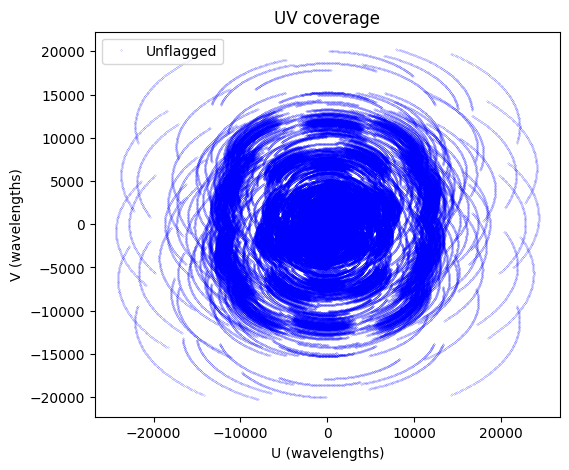

In [3]:
matplotlib.rcParams['figure.figsize'] = [6, 5]
plot_uvcoverage([vt])


### Fill visibilities amplitude from (Fourier plane values) of image in FITS file. Cell size corresponds to the (advised) pixel angular size in radians. Uses Nifty gridder.

In [4]:
vt, cell_size, im = visibilities_from_image(vt,'data/Meerkat_Galactic_center_512_ext.fits',return_cellsize=True,return_image=True,scale_factor=2.2)

stdv_real = numpy.std(numpy.array(vt.vis.real).flatten())
stdv_imag = numpy.std(numpy.array(vt.vis.imag).flatten())

print(stdv_real)
print(stdv_imag)

stdv_real /= 50
stdv_imag /= 50

noise_real = numpy.random.normal(loc=0, scale=stdv_real, size=vt.vis.shape)
noise_imag = numpy.random.normal(loc=0, scale=stdv_imag, size=vt.vis.shape)

noise = numpy.vectorize(complex)(noise_real, noise_imag)
vis_with_noise = vt.vis + noise
vt["vis"].data = vis_with_noise
#vt, cell_size, im = visibilities_from_image(vt,'data/toto_ext.fits',return_cellsize=True,return_image=True,scale_factor=1.)

advise_wide_field: (max_wavelength) Maximum wavelength 0.300 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.300 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 24331.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 10597.6 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 13.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0222 (rad) 1.27 (deg) 4.58e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.0666 (rad) 3.82 (deg) 1.37e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 4.11e-05 (rad) 0.00235 (deg) 8.48 (asec)
advise_wide_field: (cellsize) Cellsize 1.03e-05 (rad) 0.000589 (deg) 2.12 (asec)
advice_wide_field: (npixels) Npixels per side = 6484
advice_wide_field: (npixels2) Npixels (power of 2) per side = 8192
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 8192
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 6561

advice_wide_field: (w_sa

### Export visibility data to measurement set file

In [5]:
from rascil.processing_components import export_visibility_to_ms
#export_visibility_to_ms('data/SGRB.ms',[vt])
#export_visibility_to_ms('data/Meerkat_SGRC_shortexp.ms',[vt])

### Convert radius of uv hole from lambda to pixels

In [6]:
radius = 7000
delta_radius = 1000
npixels = 512
radius_pixel = radius * cell_size * npixels
delta_radius_pixel = delta_radius * cell_size * npixels
print(cell_size)
print("uvmin_lambda,uvmax_lambda = %d,%d"%(radius-delta_radius/2,radius+delta_radius/2))
print("uvmin_pix,uvmax_pix,npix = %d,%d,%d"%(radius_pixel-delta_radius_pixel/2, 
                                             radius_pixel+delta_radius_pixel/2, npixels))

2.2604409285983003e-05
uvmin_lambda,uvmax_lambda = 6500,7500
uvmin_pix,uvmax_pix,npix = 75,86,512


### Load short and long baseline measurement sets, plot uv coverage

create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 171508 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_visibility_from_ms: Observation from 2000-01-01 17:37:07.746 to 2000-01-01 21:35:07.746
create_visibility_from_ms: {'type': 'Measurement Set', 'subType': 'UVFITS', 'readme': 'This is a MeasurementSet Table holding measurements from a Telescope\nThis is a measurement set Table holding astronomical observations\n'}
create_visibility_from_ms: Reading unique fields [0], unique data descriptions [0]
create_visibility_from_ms: Found 87509 rows
create_visibility_from_ms: Found 1 channels
create_visibility_from_ms: Reading all 1 channels
create_v

/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


There is no flagged visibility. Skip plotting flagged.


/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


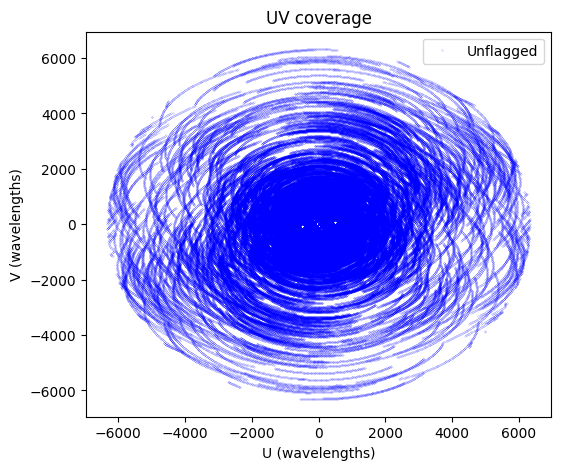

There is no flagged visibility. Skip plotting flagged.


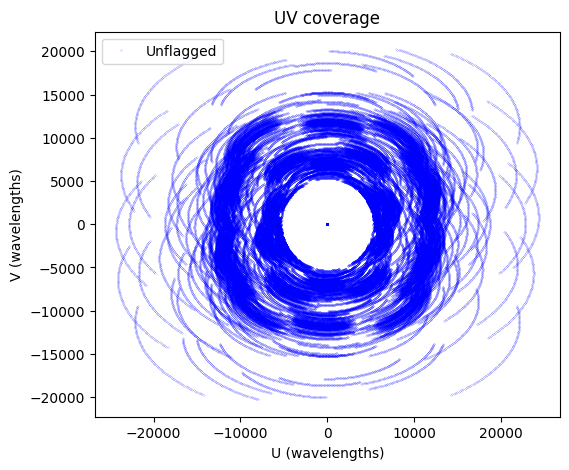

In [7]:
from rascil.processing_components import create_visibility_from_ms
[vs] = create_visibility_from_ms('data4/SGRB_small_baselines_60.ms')
[vl] = create_visibility_from_ms('data4/SGRB_long_baselines_50.ms')
plot_uvcoverage([vs])
plot_uvcoverage([vl])


### Plot visibility amplitudes as a function of uv radius

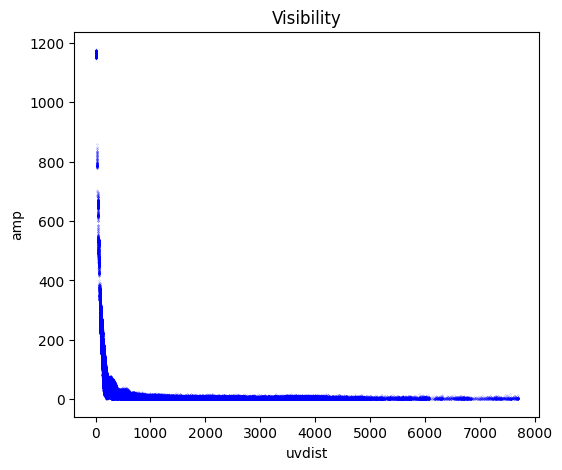

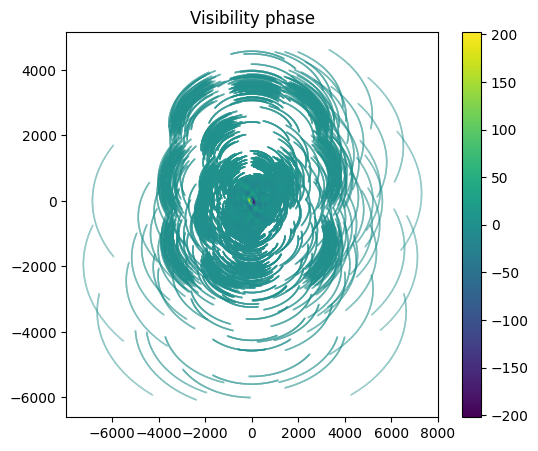

In [8]:
#vv = np.ones(vt.vis.shape)
#vt["vis"].data = vv

plot_visibility([vt])
u = vt.visibility_acc.u.data
v = vt.visibility_acc.v.data
c = numpy.imag(vt.vis.data)

plt.title('Visibility phase')
plt.scatter(u,v,c=c,marker='.', s=0.1)
plt.colorbar()


### Create empty (rascil) image from visibility metadata. Then predict dirty and psf images using nifty gridder (adjoint)

In [9]:
dirty, psf = dirty_psf_from_visibilities(vt,cell_size,npix=512,weighting="uniform")
dirty_short, psf_short = dirty_psf_from_visibilities(vs,cell_size,npix=512,weighting="uniform")
dirty_long, psf_long = dirty_psf_from_visibilities(vl,cell_size,npix=512,weighting="uniform")

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 2.26044e-05 radians, 0.00129514 degrees
create_image_from_visibility: Resetting cellsize 2.26044e-05 radians to criticalcellsize 2.05495e-05 radians
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 4.238631e+00
warning visibility_weight_to_griddata gridding: skipped 14 visbility
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and

### Visualize original image, dirty image and psf

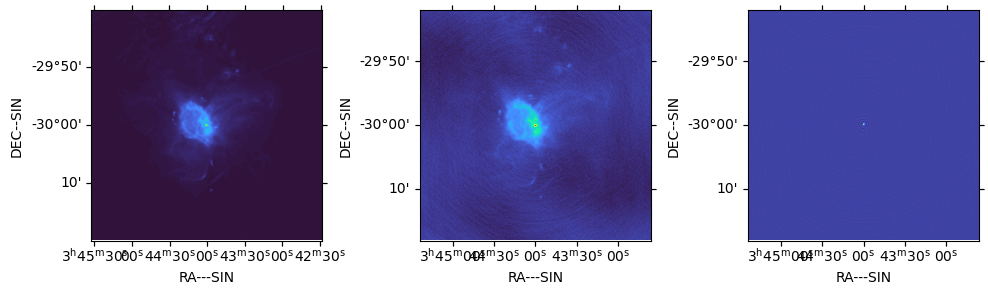

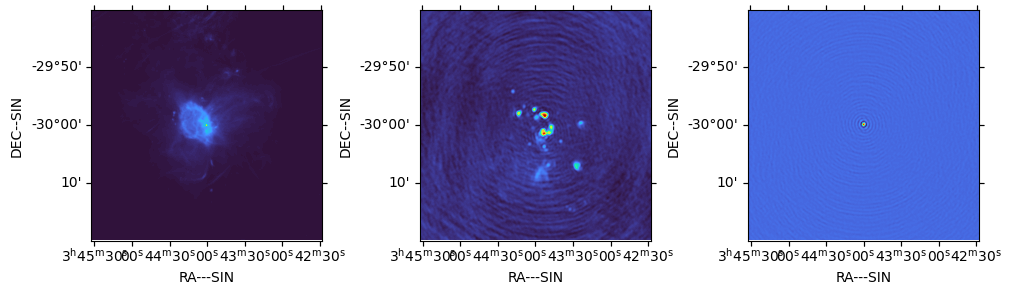

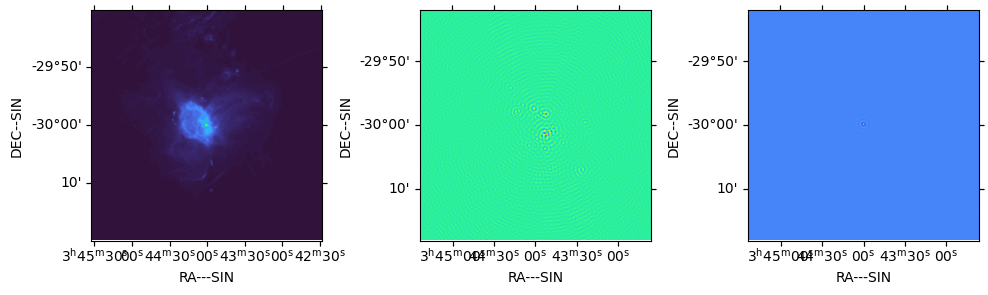

In [10]:
#show_image(im,cm=cmap)
#show_image(dirty,cm=cmap)
#show_image(psf,cm=cmap)
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf.image_acc.wcs.sub([1, 2]))
ax.imshow(psf.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf.image_acc.wcs.wcs.ctype[1])

# Now for short baselines only
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty_short.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty_short.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty_short.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty_short.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf_short.image_acc.wcs.sub([1, 2]))
ax.imshow(psf_short.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf_short.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf_short.image_acc.wcs.wcs.ctype[1])

# Now for long baselines only
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty_long.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty_long.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty_long.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty_long.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf_long.image_acc.wcs.sub([1, 2]))
ax.imshow(psf_long.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf_long.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf_long.image_acc.wcs.wcs.ctype[1])


### Export dirty, psf to fits

In [11]:
# Export dirty, psf
dirty.image_acc.export_to_fits('data/Meerkat_Galactic_center_dirty.fits')
psf.image_acc.export_to_fits('data/Meerkat_Galactic_center_psf.fits')
dirty_short.image_acc.export_to_fits('data/Meerkat_Galactic_center_dirty_short.fits')
psf_short.image_acc.export_to_fits('data/Meerkat_Galactic_center_psf_short.fits')
dirty_long.image_acc.export_to_fits('data/Meerkat_Galactic_center_dirty_long.fits')
psf_long.image_acc.export_to_fits('data/Meerkat_Galactic_center_psf_long.fits')


(-0.05, 1.0)

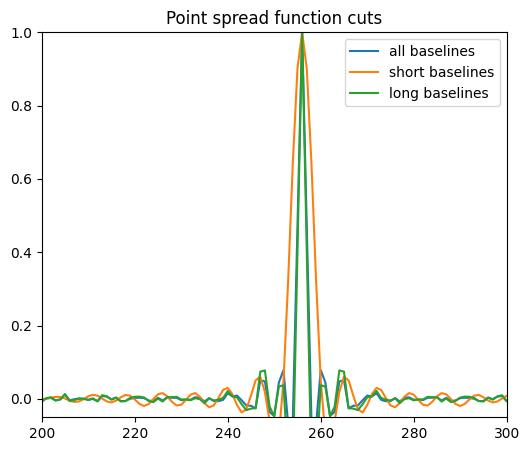

In [12]:
plt.plot(psf['pixels'].data[0,0,256,:],label='all baselines')
plt.plot(psf_short['pixels'].data[0,0,256,:],label='short baselines')
plt.plot(psf_long['pixels'].data[0,0,256,:],label='long baselines')
plt.legend()
plt.title('Point spread function cuts')
plt.xlim((200,300)); plt.ylim((-0.05,1))

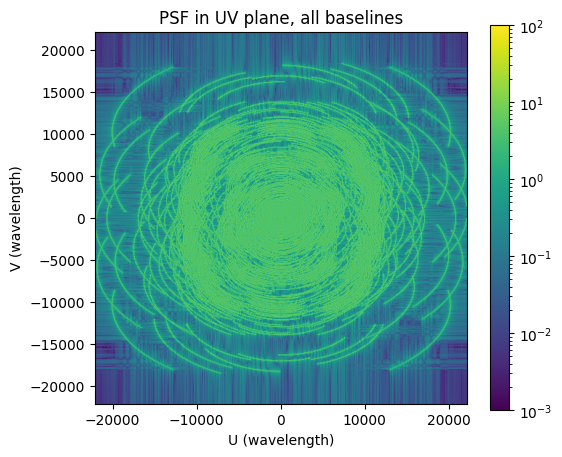

In [13]:
uv_psf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf.pixels.data.squeeze())))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf),norm=LogNorm(vmin=0.001,vmax=100),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.title('PSF in UV plane, all baselines')
plt.colorbar()

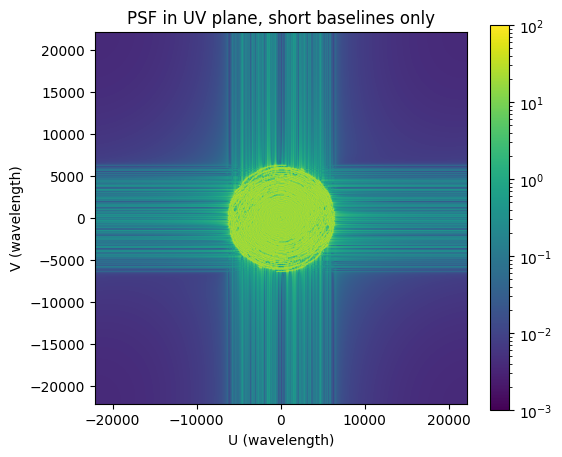

In [14]:
uv_psf_short = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf_short.pixels.data.squeeze())))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf_short),norm=LogNorm(vmin=0.001,vmax=100),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.title('PSF in UV plane, short baselines only')
plt.colorbar()

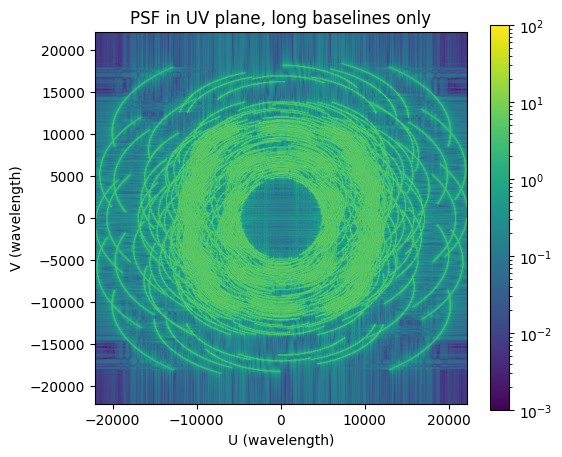

In [15]:
uv_psf_long = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf_long.pixels.data.squeeze())))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf_long),norm=LogNorm(vmin=0.001,vmax=100),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.title('PSF in UV plane, long baselines only')
plt.colorbar()

In [16]:
from astropy.io import fits as pyfits
hdu = pyfits.PrimaryHDU(np.real(uv_psf))
hdu.writeto("uv_psf.fits",overwrite=True)

In [17]:
nrows,nbaselines, _ = vt.uvw.shape

In [18]:
uv=vt.visibility_acc.uvw_lambda[...,0:2]
uv = uv.reshape(nrows*nbaselines,2)

In [19]:
uv.shape

(249600, 2)

In [20]:
from scipy.spatial import KDTree
tree = KDTree(uv)
neighbors = tree.query_ball_tree(tree,r=100)

In [21]:
weights = 1./np.array([len(l) for l in neighbors])
weights /= np.sum(weights)
weights = weights.reshape(nrows,nbaselines,1,1)
vt.imaging_weight.data = weights


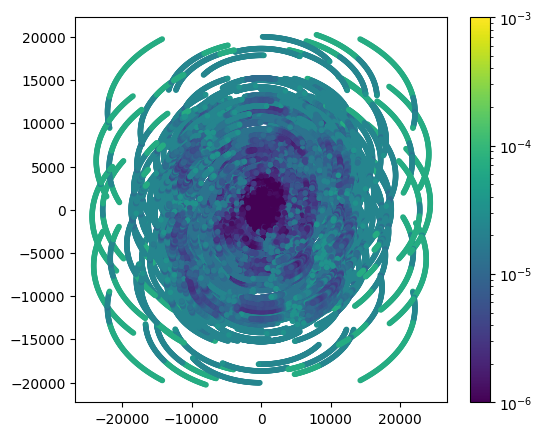

In [22]:
plt.scatter(uv[:,0],uv[:,1],c=weights,marker='.',norm=LogNorm(vmin=0.000001,vmax=0.001))
plt.scatter(-uv[:,0],-uv[:,1],c=weights,marker='.',norm=LogNorm(vmin=0.000001,vmax=0.001))
plt.colorbar()

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 6333.081983 wavelengths
create_image_from_visibility: Critical cellsize = 0.000079 radians, 0.004524 degrees
create_image_from_visibility: Cellsize = 2.26044e-05 radians, 0.00129514 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 4.662494e+00


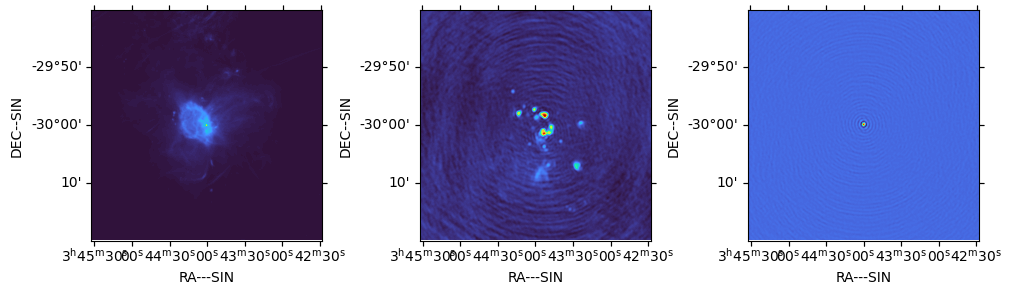

In [23]:

dirty, psf = dirty_psf_from_visibilities(vs,cell_size,npix=512)
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,3,1,projection=im.image_acc.wcs.sub([1, 2]))
ax.imshow(im.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(im.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(im.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,2,projection=dirty.image_acc.wcs.sub([1, 2]))
ax.imshow(dirty.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(dirty.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(dirty.image_acc.wcs.wcs.ctype[1])

ax=fig.add_subplot(1,3,3,projection=psf.image_acc.wcs.sub([1, 2]))
ax.imshow(psf.pixels.data[0,0,:,:],origin='lower',cmap=cmap)
ax.set_xlabel(psf.image_acc.wcs.wcs.ctype[0])
ax.set_ylabel(psf.image_acc.wcs.wcs.ctype[1])


(-0.1, 1.0)

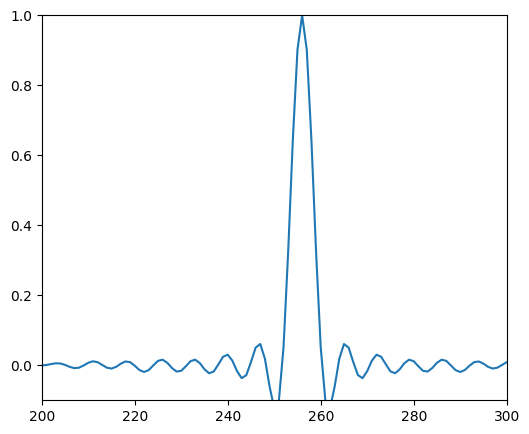

In [24]:
plt.plot(psf['pixels'].data[0,0,256,:])
plt.xlim((200,300)); plt.ylim((-0.1,1))

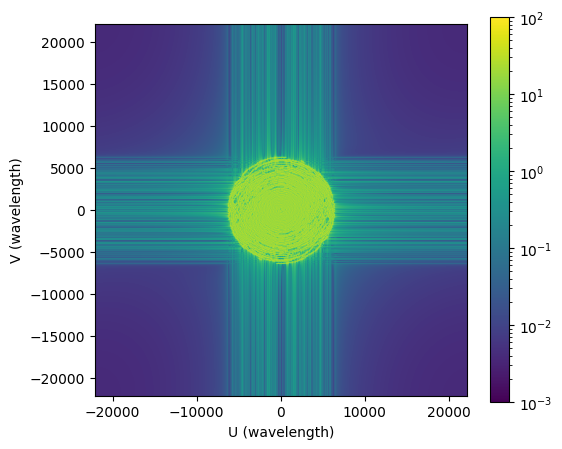

In [25]:
uv_psf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(psf.pixels.data.squeeze())))
from matplotlib.colors import LogNorm
uv_size = 1./cell_size/2.
plt.imshow(np.abs(uv_psf),norm=LogNorm(vmin=0.001,vmax=100),extent=[-uv_size,uv_size,-uv_size,uv_size])
plt.xlabel('U (wavelength)')
plt.ylabel('V (wavelength)')
plt.colorbar()

In [26]:
1./cell_size / 256 * 50

8640.460253969712

## Test to compare RASCIL and WSClean convolutions to circular and linear

In [27]:
from visibilities import *
from images import *

matplotlib.rcParams['figure.figsize'] = [10, 5]

phasecentre = SkyCoord(ra=+56.0 * u.deg, dec=-30.0 * u.deg, frame='icrs', equinox='J2000')
ha_interval=(-2,2)
vt = generate_visibilities(phasecentre,ha_interval,tel="MEERKAT", integration_time=120)
vt, cell_size, im = visibilities_from_image(vt,'data/badly_centered.fits',return_cellsize=True,return_image=True,scale_factor=1.8)
#export_visibility_to_ms('data/badly_centered.ms',[vt])
dirty, psf = dirty_psf_from_visibilities(vt,cell_size,npix=512,weighting="uniform")

dirty = dirty.pixels.data
while len(dirty.shape) > 2:
    dirty = dirty[0]
    
psf = psf.pixels.data
while len(psf.shape) > 2:
    psf = psf[0]
    
gt = helpers.readFits("data/badly_centered.fits")
while len(gt.shape) > 2:
    gt = gt[0]

nifty = dirty
circular = helpers.circularConv(gt, psf)
linear = helpers.linearConv(gt, psf)
linearscipy = helpers.linearConvScipy(gt, psf)

wsclean = helpers.readFits("badly_centered_wsclean.fits")
wsclean_nifty = helpers.readFits("badly_centered_wsclean_nifty.fits")

create_named_configuration: MEERKAT
	(<Quantity 5109360.08350152 m>, <Quantity 2006852.56658911 m>, <Quantity -3238948.21751511 m>)
	GeodeticLocation(lon=<Longitude 21.44388889 deg>, lat=<Latitude -30.7110565 deg>, height=<Quantity 1086.6 m>)
create_configuration_from_file: 64 antennas/stations
create_visibility: created 120 times
create_visibility: 249600 rows, 0.013 GB
advise_wide_field: (max_wavelength) Maximum wavelength 0.300 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 0.300 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 24331.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 10597.6 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 13.5 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0222 (rad) 1.27 (deg) 4.58e+03 (asec)
advise_wide_field: (image_fov) Image field of view 0.0666 (rad) 3.82 (deg) 1.37e+04 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 4.11e-05 (rad) 0.00235 (deg) 8.48 (asec)
ad

/home/sunwang/.local/lib/python3.10/site-packages/ska_sdp_datamodels/visibility/vis_model.py:87: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'baselines' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  super().__init__(data_vars, coords=coords, attrs=attrs)


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (56., -30.)>, starting frequency 1000000000.0 Hz, and bandwidth 1000000.0 Hz
create_image_from_visibility: uvmax = 24331.536075 wavelengths
create_image_from_visibility: Critical cellsize = 0.000021 radians, 0.001177 degrees
create_image_from_visibility: Cellsize = 1.84945e-05 radians, 0.00105966 degrees
create_image_from_visibility: image shape is (1, 1, 512, 512)
Model image plate scale (arcsec) is 3.814768e+00


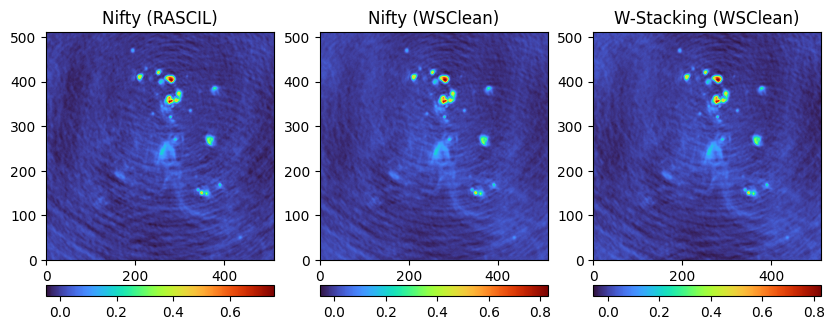

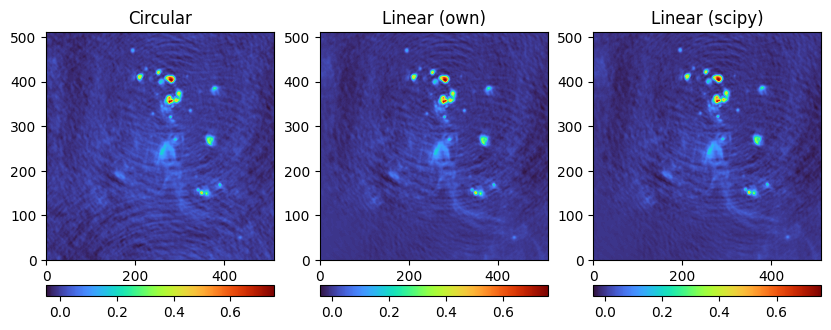

In [28]:
helpers.plotNImages([nifty, wsclean_nifty, wsclean], ["Nifty (RASCIL)", "Nifty (WSClean)", "W-Stacking (WSClean)"], cmap)
helpers.plotNImages([circular, linear, linearscipy], ["Circular", "Linear (own)", "Linear (scipy)"], cmap)

## Ground truth images of three datasets

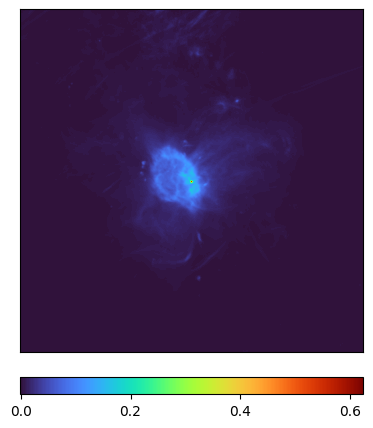

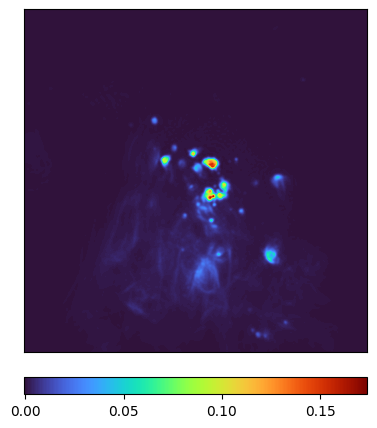

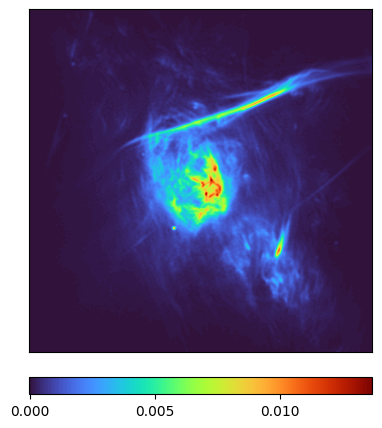

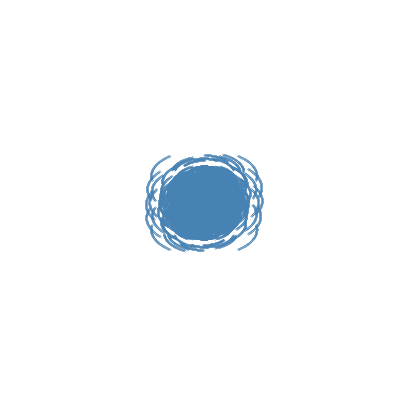

In [30]:
matplotlib.rcParams['figure.figsize'] = [5, 5]

agt = helpers.readFits("data/SGRA_full_gt.fits")
bgt = helpers.readFits("data/SGRB_full_gt.fits")
cgt = helpers.readFits("data/SGRC_full_gt.fits")

helpers.plotNImages([agt], [""], cmap, output_file="figures/SGRA_full_gt.png", hide_ticks=True)
helpers.plotNImages([bgt], [""], cmap, output_file="figures/SGRB_full_gt.png", hide_ticks=True)
helpers.plotNImages([cgt], [""], cmap, output_file="figures/SGRC_full_gt.png", hide_ticks=True)

plt.show()

u = vt.visibility_acc.u.data
v = vt.visibility_acc.v.data
c = [1]*u.size

matplotlib.rcParams['figure.figsize'] = [5, 5]

max_xy = numpy.max([numpy.max(numpy.fabs(u)), numpy.max(numpy.fabs(v))])
plt.scatter(u,v,marker='.', s=0.1, c='steelblue')
plt.scatter(-u,-v,marker='.', s=0.1, c='steelblue')
plt.xlim([-max_xy, max_xy])
plt.ylim([-max_xy, max_xy])

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.savefig("figures/uv_coverage.png", pad_inches=0.0, bbox_inches='tight')
